# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [ ]:
## Deep Learning Project - Gesture Recognition

#### Developed by:
##### 1. Vaidehi - Group facilitator
##### 2. Suresh Krishna 


### Problem Statement
Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
 
| Gesture | Corresponding Action |
| --- | --- | 
| Thumbs Up | Increase the volume. |
| Thumbs Down | Decrease the volume. |
| Left Swipe | 'Jump' backwards 10 seconds. |
| Right Swipe | 'Jump' forward 10 seconds. |
| Stop | Pause the movie. |

Each video is a sequence of 30 frames (or images).

### Objectives:
1. **Generator**:  The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

2. **Model**: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

3. **Write up**: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model. 

In [28]:
import numpy as np
import os
import imageio
import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import skimage.transform

We set the random seed so that the results don't vary drastically.

In [29]:
import os
os.environ['PYTHONHASHSEED']="30"
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
tf.random.set_seed(30)
from keras import backend as K

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [30]:
# train and validatiaon data creator with ablation
# when ablation is 10, then 10 folders for each label will be selected.
def get_data(path, ablation=None):
    train_doc = np.random.permutation(open(path+'train.csv').readlines())
    val_doc = np.random.permutation(open(path+'val.csv').readlines())
    counts = np.zeros(5) # count for loading folders for 5 classes
    train_data = []
    val_data = []
    # when ablation is None pass full training and val data
    if ablation is not None:
        # iterating train doc
        for doc in train_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                train_data.append(doc)
                counts[lable] += 1 
        counts = np.zeros(5)
        # iterating val doc
        for doc in val_doc:
            lable = int(doc.strip().split(';')[2])
            if counts[lable] < ablation:
                val_data.append(doc)
                counts[lable] += 1
    else:
        train_data, val_data = train_doc, val_doc
    return train_data, val_data

In [31]:
train_doc, val_doc = get_data('/home/datasets/Project_data/', ablation=None)
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x, dim_y = 120, 120

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [32]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size,is_train = False, augmention = False, debug=False):
    # print('\nSource path = ', source_path, '; batch size =', batch_size)
    img_idx = seq_idx #create a list of image numbers you want to use for a particular video
    x = len(img_idx)
    y, z = dim_x, dim_y
    while True:
        # doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)
            
        if (len(t)%batch_size) == 0:
            num_batches = int(len(t)/batch_size)
        else:
            num_batches = len(t)//batch_size + 1
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                if debug:
                    plt.figure(figsize=(20,5))
                #handling remaining datapoints
                folder_idx = folder + (batch*batch_size)
                if folder_idx >= len(t):
                    break
                folder_str = t[folder_idx]
                imgs = os.listdir(source_path+'/'+ folder_str.split(';')[0]) # read all the images in the folder
                # randomly enabling augmentation and augmentation type
                aug_type = None
                if is_train and augmention and rn.randint(0,1) == 1:
                    aug_type = rn.randint(0, 4) #randomly selecting augmentation type
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ folder_str.strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    # plotting original images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+1)
                        plt.imshow(image.astype('uint8'))

                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    # making the rectangle images into square by cropping sides
                    # so the aspect ration can be mantained while resizing.
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]

           
                    resized_im=skimage.transform.resize(image, (y,z))

                    if aug_type is not None:
                        if aug_type == 0: # edge Enhancement
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.EDGE_ENHANCE))
                        elif aug_type == 1: # adding gaussian blur
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.GaussianBlur(1)))
                        elif aug_type == 2: # enchancing image detailing
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.DETAIL))
                        elif aug_type == 3: # sharpening image
                            resized_im = np.array(Image.fromarray(resized_im, 'RGB').filter(ImageFilter.SHARPEN))
                        elif aug_type == 4: # Brightness enhancement
                            resized_im = np.array(ImageEnhance.Brightness((Image.fromarray(resized_im, 'RGB'))).enhance(1.5))
                    # plotting rezised images for debugging purpose only
                    if debug:
                        plt.subplot(2, x, idx+x+1)
                        plt.imshow(resized_im)
                        

                    batch_data[folder,idx,:,:,0] = resized_im[:,:,0]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = resized_im[:,:,1]/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = resized_im[:,:,2]/255 #normalise and feed in the image

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do
                

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [33]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train' #'/notebooks/storage/Final_data/Collated_training/train'
val_path =  '/home/datasets/Project_data/val' #'/notebooks/storage/Final_data/Collated_training/val'

#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 50 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


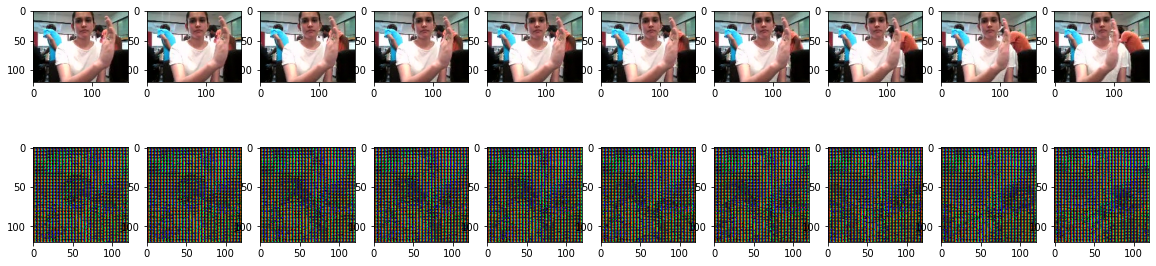

In [34]:
# testing generative 
test_gen = generator(train_path, train_doc, 1, is_train = True, augmention = True, debug = True)
d = next(test_gen)[0]

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [35]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D
from keras.layers.convolutional import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

### Experiment - 1 
**Conv3D with no drop outs  very simple model**

In [43]:
model = Sequential()
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [44]:
num_epochs=10
optimiser = tf.keras.optimizers.Adam(0.01)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_34 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_25 (MaxPoolin  (None, 4, 59, 59, 32)    0         
 g3D)                                                            
                                                                 
 conv3d_35 (Conv3D)          (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_26 (MaxPoolin  (None, 1, 28, 28, 64)    0         
 g3D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 256)             

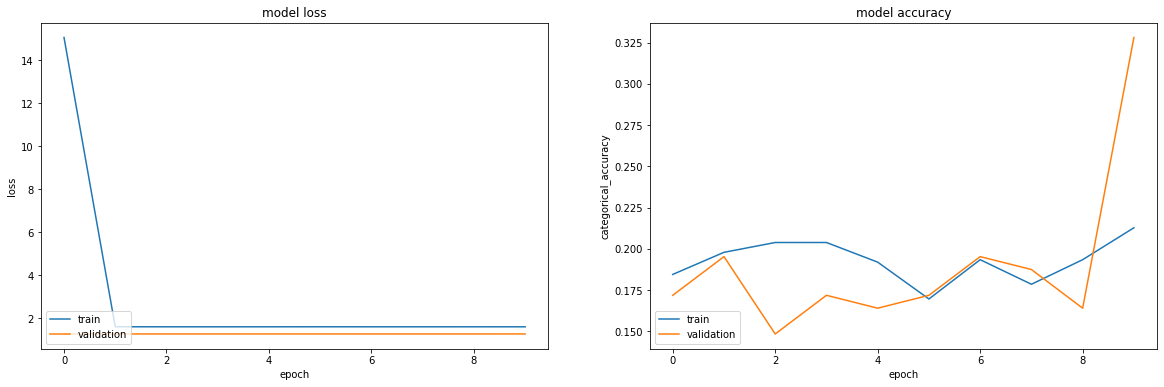

In [45]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

## CONCLUSION

##### The model is underfitting

### Experiment - 2
**Conv3D added more layers**

In [49]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, kernel_size=3, activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(3, 2, 2),padding='same'))

model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu',padding='same'))
model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu',padding='same'))
model.add(MaxPooling3D(pool_size=(2, 2, 2),padding='same'))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_48 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_49 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 3, 58, 58, 64)    0         
 g3D)                                                            
                                                                 
 conv3d_50 (Conv3D)          (None, 3, 58, 58, 128)    221312    
                                                                 
 max_pooling3d_37 (MaxPoolin  (None, 1, 29, 29, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_51 (Conv3D)          (None, 1, 29, 29, 256)  

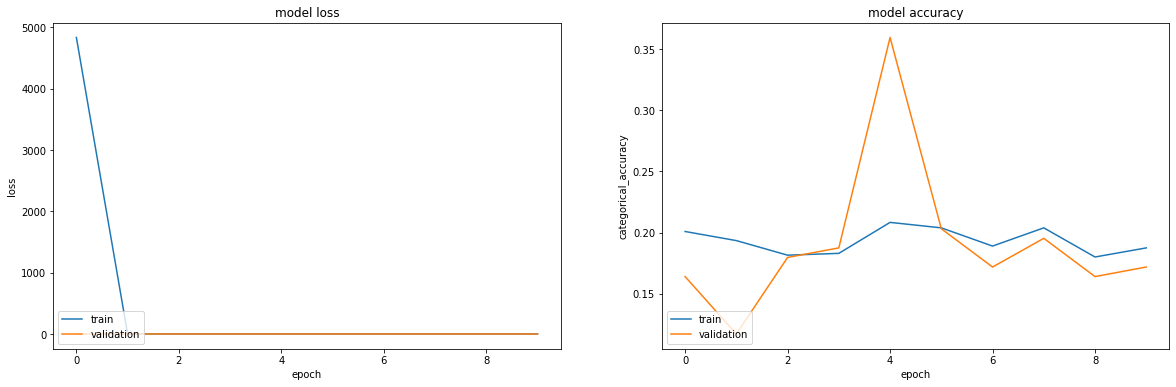

In [50]:
num_epochs=10
optimiser = tf.keras.optimizers.Adam(0.01)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### CONCLUSION

#### No improvement in model 

### Experiment - 3
**Conv3D with dropout and batch normalisation**

In [35]:
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [36]:
optimiser = tf.keras.optimizers.Adam(0.01)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_5 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 3, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 1, 56, 56, 128)   

In [37]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)


In [38]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

In [39]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [40]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.4229 - categorical_accuracy: 0.3318
Epoch 00001: saving model to model_init_exp_16_2022-11-1109_53_24.493498/model-00001-2.42289-0.33185-1120.46777-0.39844.h5
21/21 [==============================] - 54s 3s/step - loss: 2.4229 - categorical_accuracy: 0.3318 - val_loss: 1120.4678 - val_categorical_accuracy: 0.3984 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.7131 - categorical_accuracy: 0.3512
Epoch 00002: saving model to model_init_exp_16_2022-11-1109_53_24.493498/model-00002-1.71312-0.35119-233.20937-0.15625.h5
21/21 [==============================] - 52s 3s/step - loss: 1.7131 - categorical_accuracy: 0.3512 - val_loss: 233.2094 - val_categorical_accuracy: 0.1562 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.2952 - categorical_accuracy: 0.4479
Epoch 00003: saving model to model_init_exp_16_2022-11-1109_53_24.493498/model-00003-1.29517-0.44792

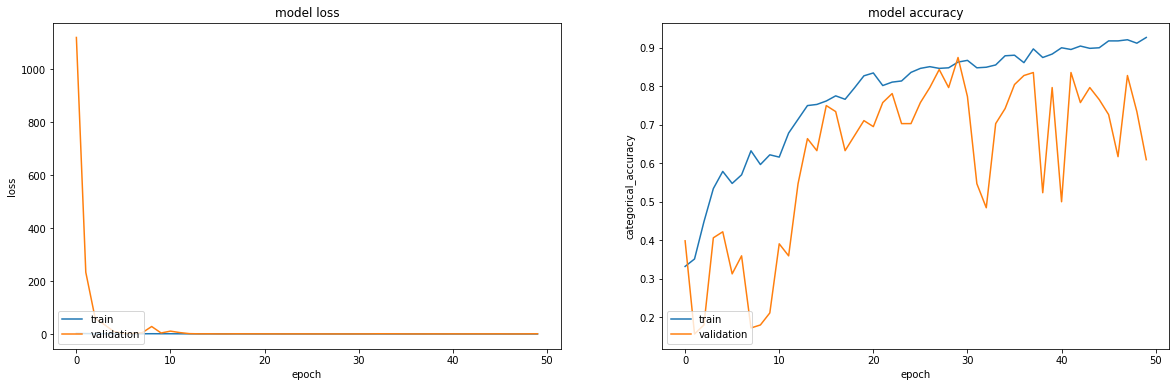

In [41]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

### Experiment - 4
**TimeDistributed Conv2D + GRU**

In [55]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(32, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(
    Conv2D(64, (3,3), activation='relu'))
)
model.add(TimeDistributed(
    MaxPooling2D((2,2)))
)
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [57]:
num_epochs=50
optimiser = tf.keras.optimizers.Adam(0.01)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 10, 59, 59, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 10, 28, 28, 64) 

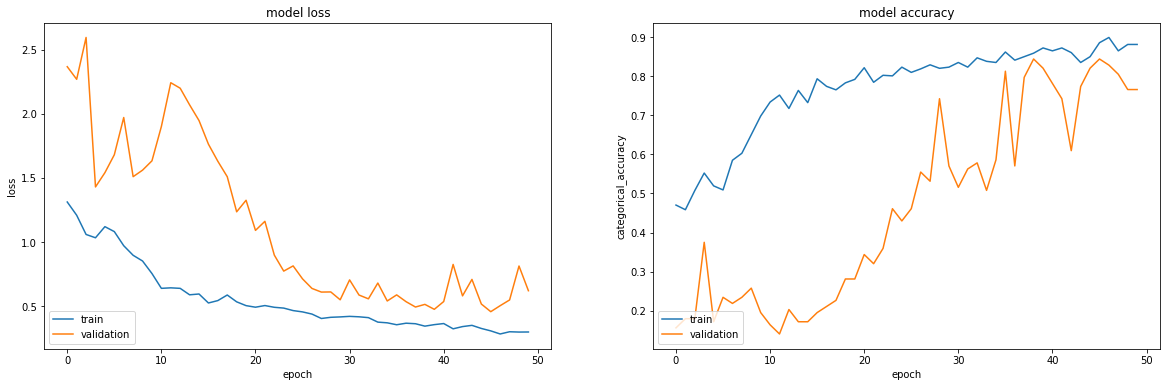

In [58]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

# Final Model

In [12]:
model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=input_shape)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))

2022-11-11 07:59:17.926835: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-11-11 07:59:17.926908: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14802 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [14]:
optimiser = tf.keras.optimizers.Adam(0.01)  #write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [15]:
train_generator = generator(train_path, train_doc, batch_size, is_train = True, augmention = enable_augmentation)
val_generator = generator(val_path, val_doc, batch_size)

In [16]:
model_name = 'model_init_exp_16' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1) # write the REducelronplateau code here

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [17]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [18]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/50


2022-11-11 08:01:09.394625: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.3196 - categorical_accuracy: 0.3824
Epoch 00001: saving model to model_init_exp_16_2022-11-1107_59_03.572189/model-00001-1.31963-0.38244-1.87090-0.17969.h5
21/21 [==============================] - 58s 3s/step - loss: 1.3196 - categorical_accuracy: 0.3824 - val_loss: 1.8709 - val_categorical_accuracy: 0.1797 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1289 - categorical_accuracy: 0.4896
Epoch 00002: saving model to model_init_exp_16_2022-11-1107_59_03.572189/model-00002-1.12890-0.48958-1.53318-0.18750.h5
21/21 [==============================] - 53s 3s/step - loss: 1.1289 - categorical_accuracy: 0.4896 - val_loss: 1.5332 - val_categorical_accuracy: 0.1875 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.0216 - categorical_accuracy: 0.5342
Epoch 00003: saving model to model_init_exp_16_2022-11-1107_59_03.572189/model-00003-1.02163-0.53423-1.66531-0.14062.h5
2

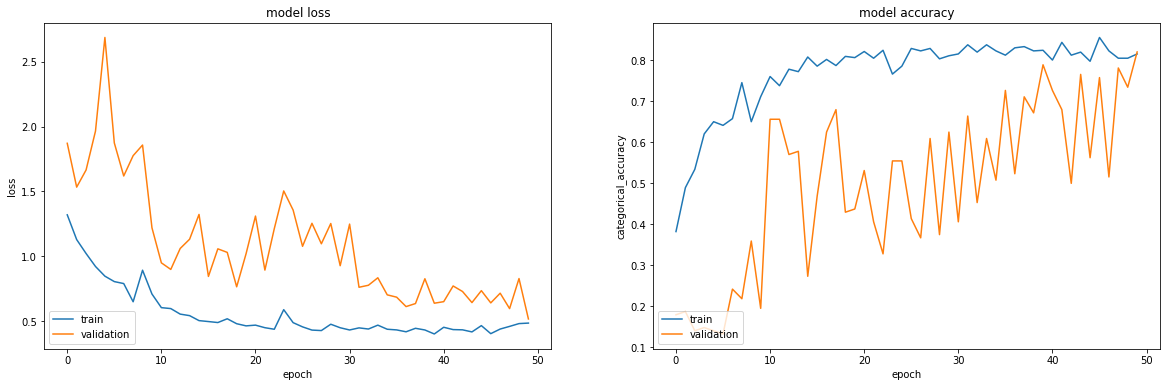

In [19]:
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')